# Overall price 

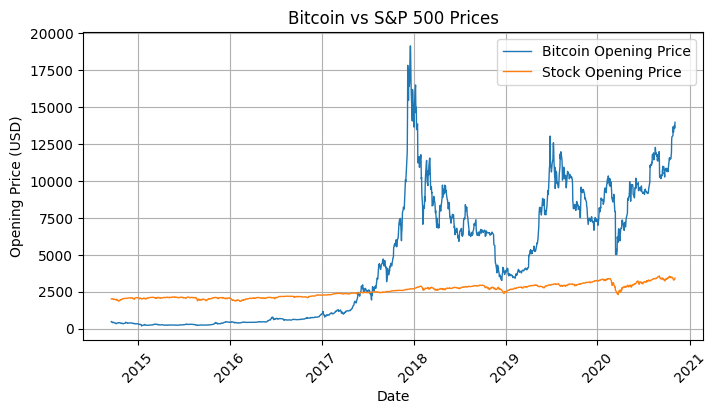

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

prices = pd.read_csv('./Processed/combined_prices.csv')

prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.sort_values('Date')
prices.set_index('Date', inplace=True)


plt.figure(figsize=(8, 4)) 
plt.plot(prices.index, prices['Open_B'], label='Bitcoin Opening Price', linewidth=1)
plt.plot(prices.index, prices['Open_S'], label='Stock Opening Price', linewidth=1)

plt.title('Bitcoin vs S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Opening Price (USD)')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.show()

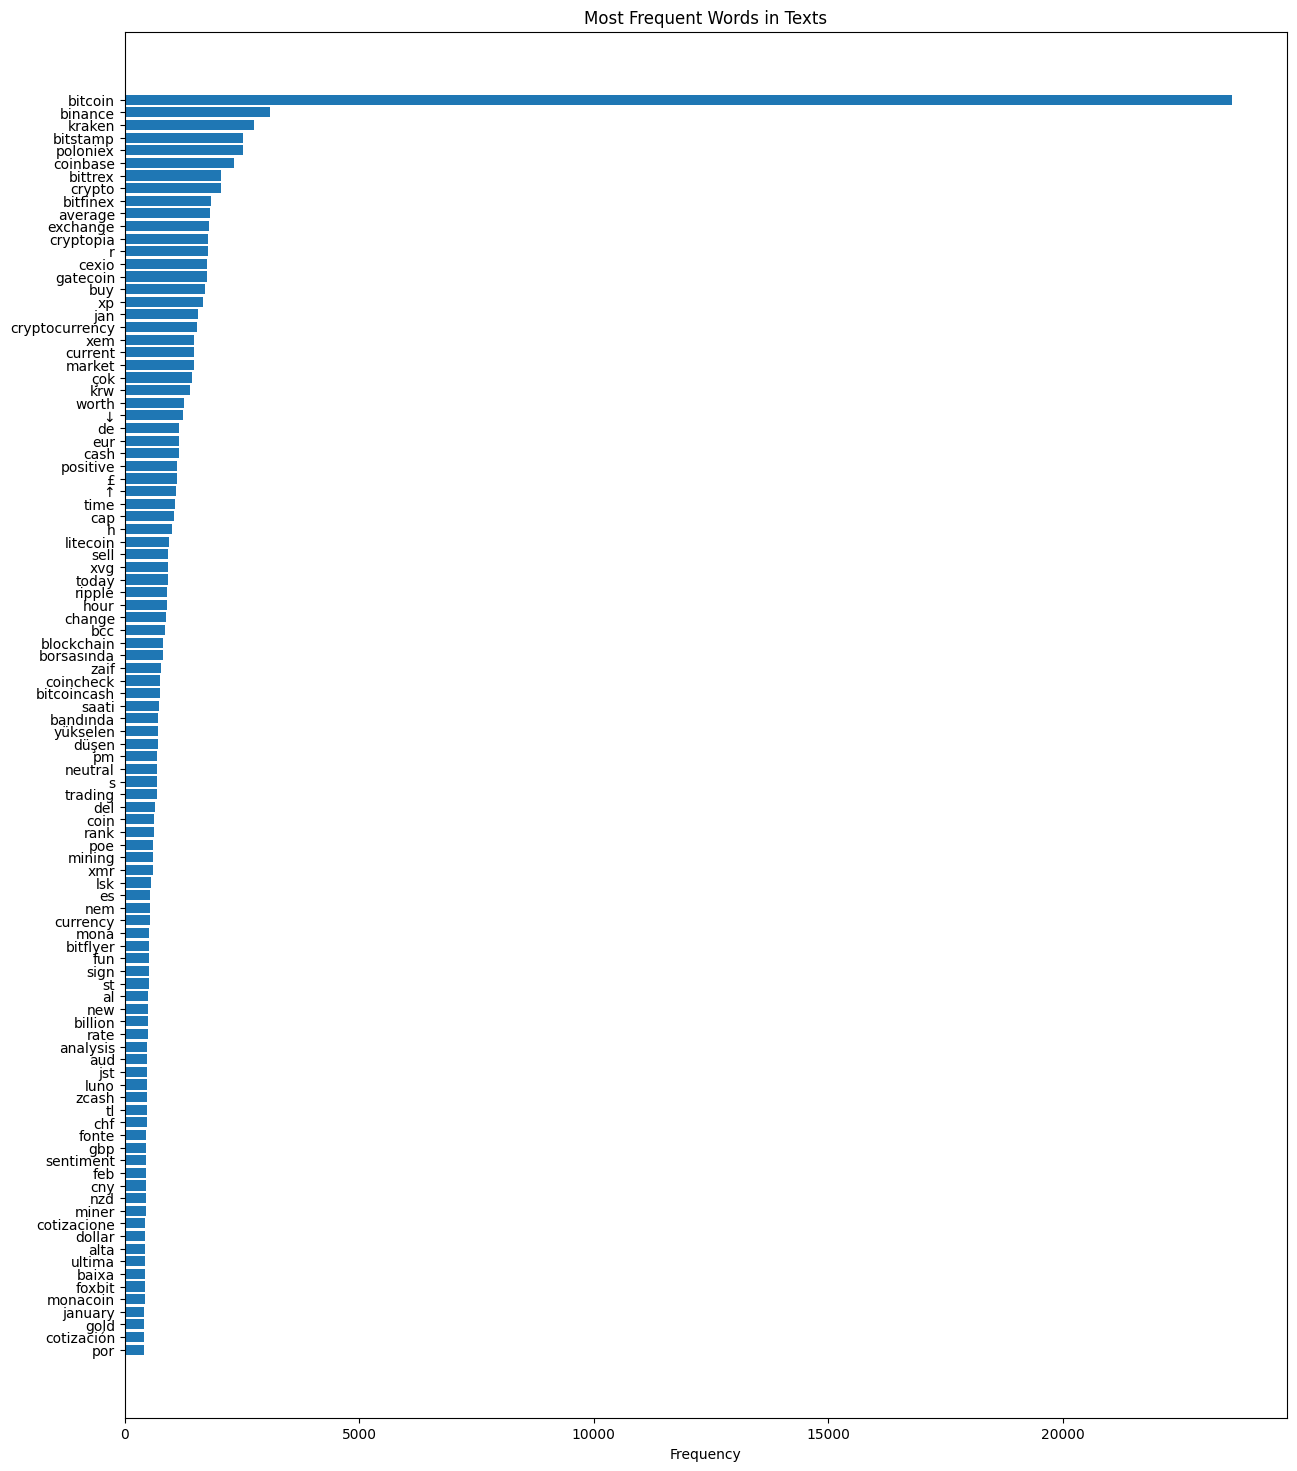

<bound method NDFrame.tail of             Date                                               body
0     2018-01-07  [crypto, currency, sentiment, analysis, bitcoi...
1     2018-01-07         [jan, £, bitcoin, pictwittercomexscxugykc]
2     2018-01-07                          [current, bitcoin, chain]
3     2018-01-07                                   [bitcoin, worth]
4     2018-01-07           [bitcoin, trade, check, realtime, price]
...          ...                                                ...
24795 2018-02-06  [australian, bank, ban, credit, cardbase, bitc...
24796 2018-02-06  [ethradebitcoin, passive, monthly, return, por...
24797 2018-02-06  [let, right, propose, free, market, barter, sy...
24798 2018-02-06  [cryptocurrency, market, news, bitcoin, crash,...
24799 2018-02-06  [bilibit, coinblb, airdrop, token, airdrop, pa...

[24800 rows x 2 columns]>

In [13]:
from collections import Counter

visu_words = pd.read_pickle('visu_words.pkl')

word_counter = Counter()

for tokens in visu_words['body']:
    word_counter.update(tokens)

words, counts = zip(*word_counter.most_common(100))

plt.figure(figsize=(15, 18))
plt.barh(words[::-1], counts[::-1])
plt.xlabel('Frequency')
plt.title('Most Frequent Words in Texts')
plt.show()
visu_words.tail
